# Predicting Air Quality using time seriesmodel in Dar es Salaam 🇹🇿

# Welcome 👋

In this project, you'll work with data from one of Africa's largest open data platforms openAfrica. You'll look at air quality data from Nairobi, Lagos, and Dar es Salaam; and build a time seriesmodel to predict PM 2.5 readings throughout the day.

In [ ]:
# Import libraries here
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.express as px

from statsmodels.tsa.ar_model import AutoReg
from pprint import PrettyPrinter
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Prepare data

## Connect to db

In [ ]:
# we will use mongo db
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"] 
dar = db["dar-es-salaam"]

In [ ]:
# Print the first document in dar-es-salaam collection
result = dar.find_one({})
pp.pprint(result)

In [ ]:
# we have tow sites
sites = dar.distinct("metadata.site")
sites

[11, 23]

In [ ]:
#The number of sensors in each site 
result = dar.aggregate([
    {"$group": {"_id": "$metadata.site", "count": {"$count": {}}}}
])
readings_per_site = list(result)
readings_per_site

## Import

In [ ]:
def wrangle(collection):
    # extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection.
    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
    
    # Remove all outlier that above of 100
    df = df[df["P2"] < 100]
    
    # Resample data by hour (is like group my data hour by hour ) & Imput missing values since the last know value (ffil())
    y = df["P2"].resample("H").mean().ffill()

    return y

In [ ]:
y = wrangle(dar)
y.head()

## Explore 

In [ ]:
# time series plot of the readings in y
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(
xlabel="Date",
ylabel="PM2.5 Level",
title="Dar es Salaam PM2.5 Levels"
) 

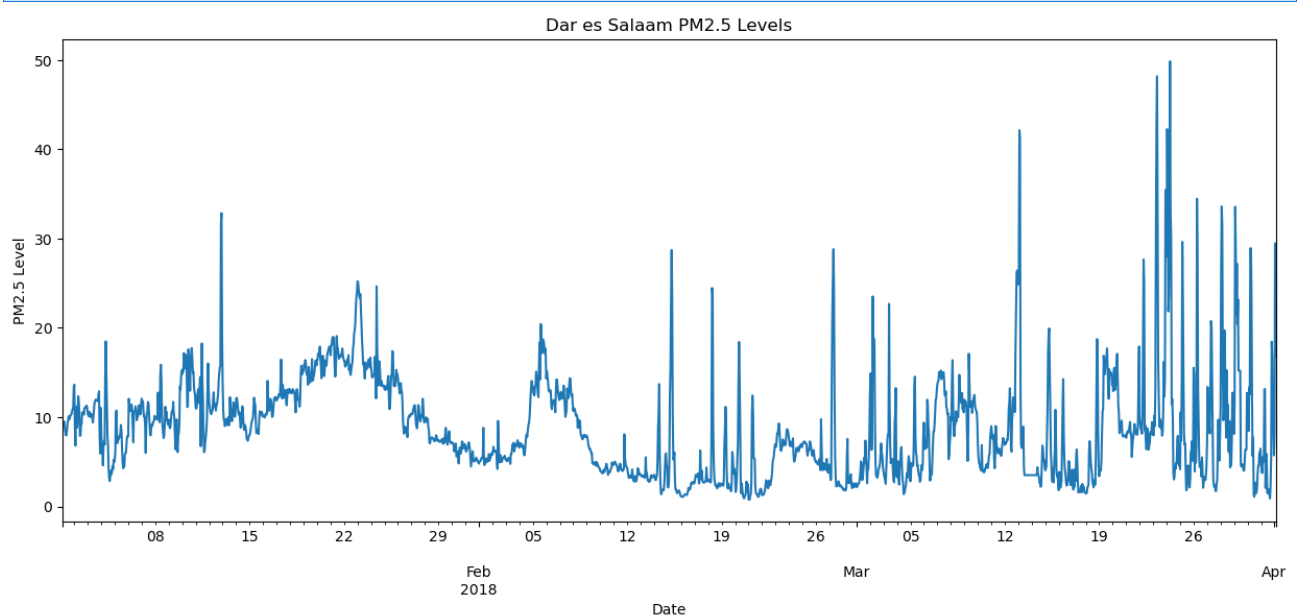

In [ ]:
# Plot the rolling average
y.rolling(window=168).mean() 
fig, ax = plt.subplots(figsize=(15, 6))
# Use a window size of 168 (the number of hours in a week )
y.rolling(168).mean().plot(ax=ax, ylabel="Weekly rolling average ");

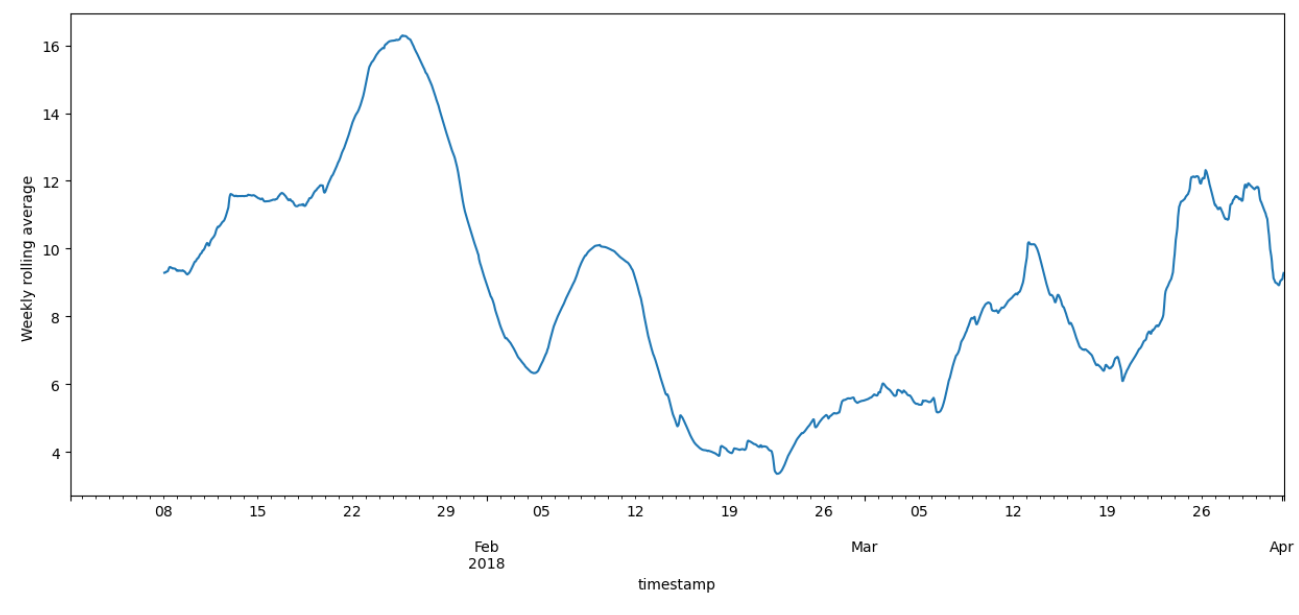

In [ ]:
# Plot an ACF plot of our data
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF")

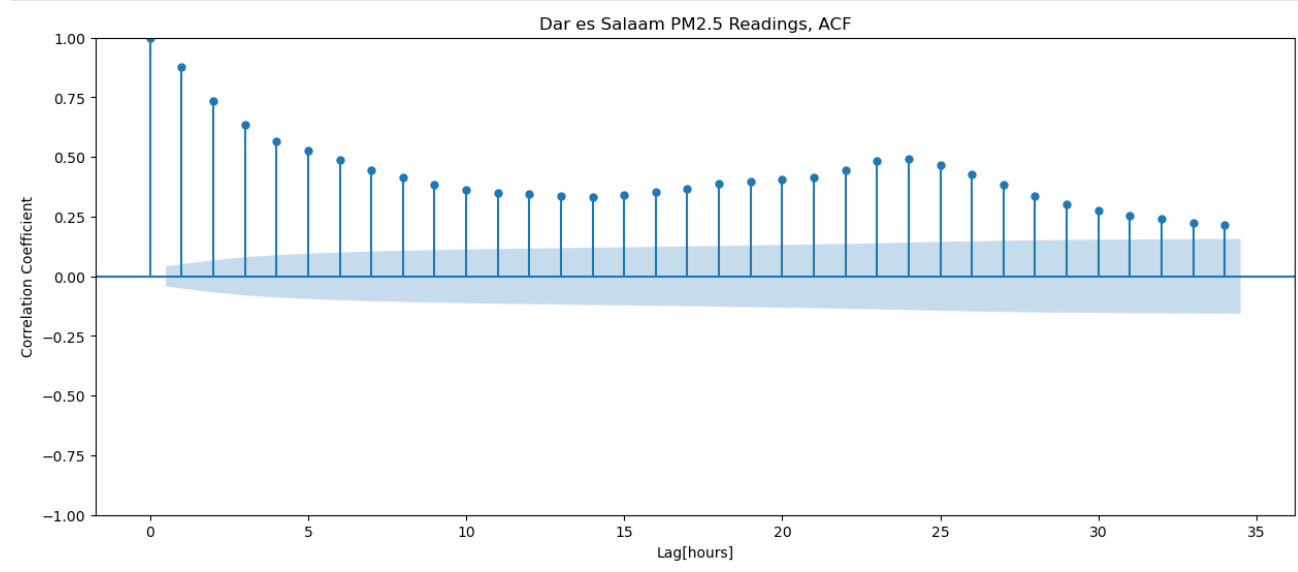

In [ ]:
# Plot an PACF plot of our data
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF")

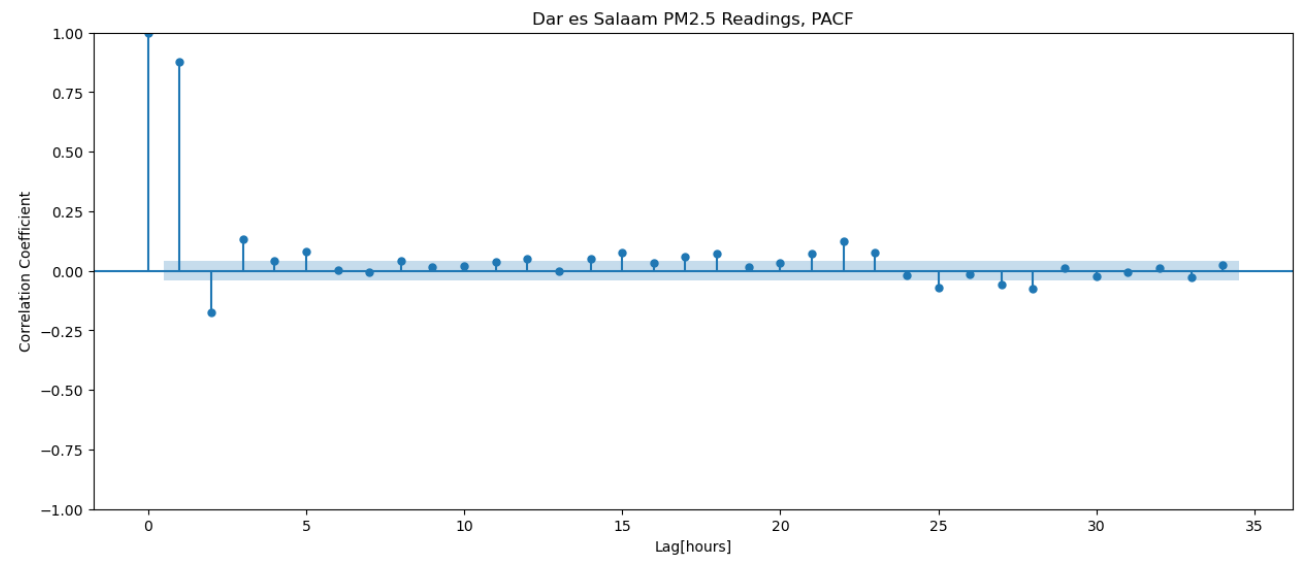

## Split 

In [ ]:
# Split the data more than 90 for training set and 10 for testing set
cutoff_test = int(len(y) * 0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Build model

### Baseline

In [ ]:
# Establish the baseline mean absolute error for our model.
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

### Iterate

In [ ]:
# Train our AR model on using settings for lags from 1 to 30. 
# Each time we will train a new model, calculate its mean absolute error and append the result to the list maes.
# Then store our results in the Series mae_series.

# Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train, lags=p)
    
    # Fit the model
    model_fit = model.fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model_fit.predict(start=p, end=len(y_train)-1).dropna()
    
    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    
    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
print(mae_series)

In [ ]:
best_p = mae_series.idxmin()
best_model = AutoReg(y_train, lags=best_p).fit()
y_train_resid = pd.Series(best_model.resid)
y_train_resid.name = "residuals"
y_train_resid.head()

In [ ]:
# Create a histogram of y_train_resid 
fig, ax = plt.subplots(figsize=(15, 6))

# Plot histogram of residuals
plt.hist(y_train_resid, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals")
plt.show()


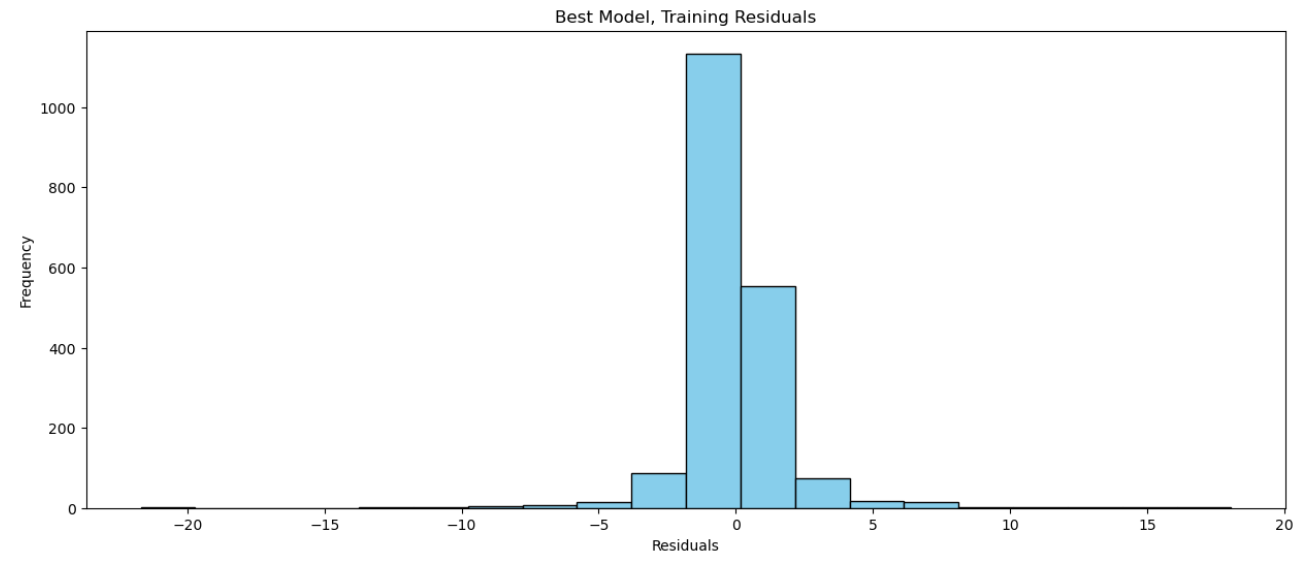

In [ ]:
# Create an ACF plot for y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam, Training Residuals ACF")

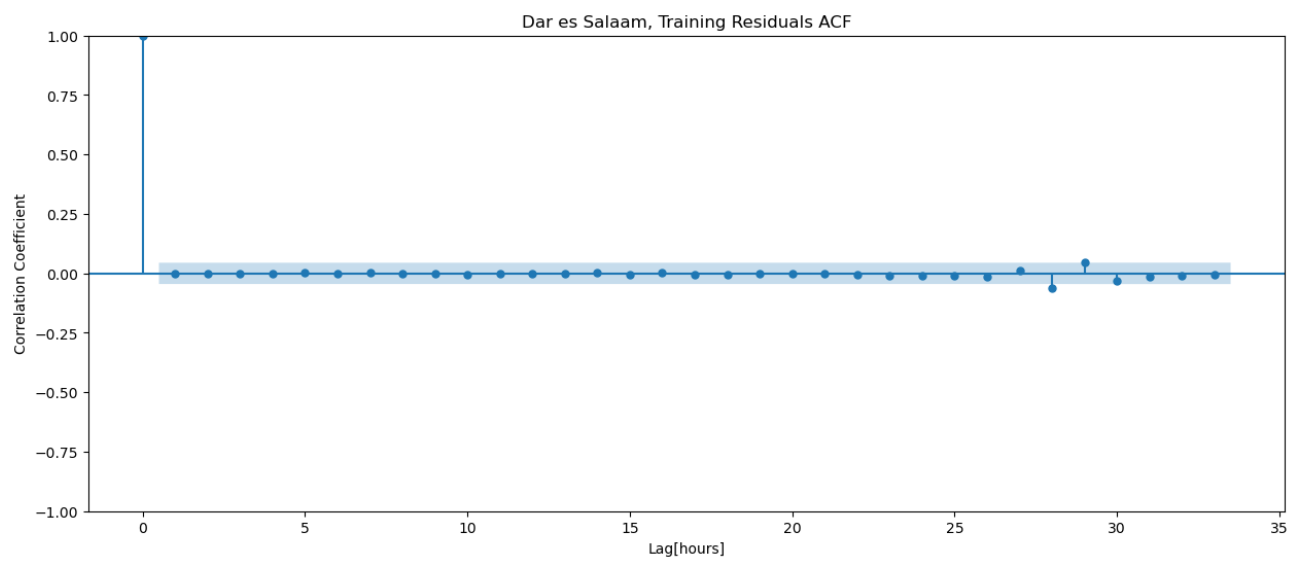

## Evaluate

In [ ]:
# Perform walk-forward validation for our model for the entire test set y_test

# Initialize an empty Series to store predictions
y_pred_wfv = pd.Series(name="prediction")
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

# Set names for the Series and its index
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.name = "prediction"

# Display the first few predictions
y_pred_wfv.head()

# Communicate results

In [ ]:
# Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv}, index=y_test.index)
# Plotly express.
fig = px.line(df_pred_test)
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
# Don't delete the code below 👇
fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()

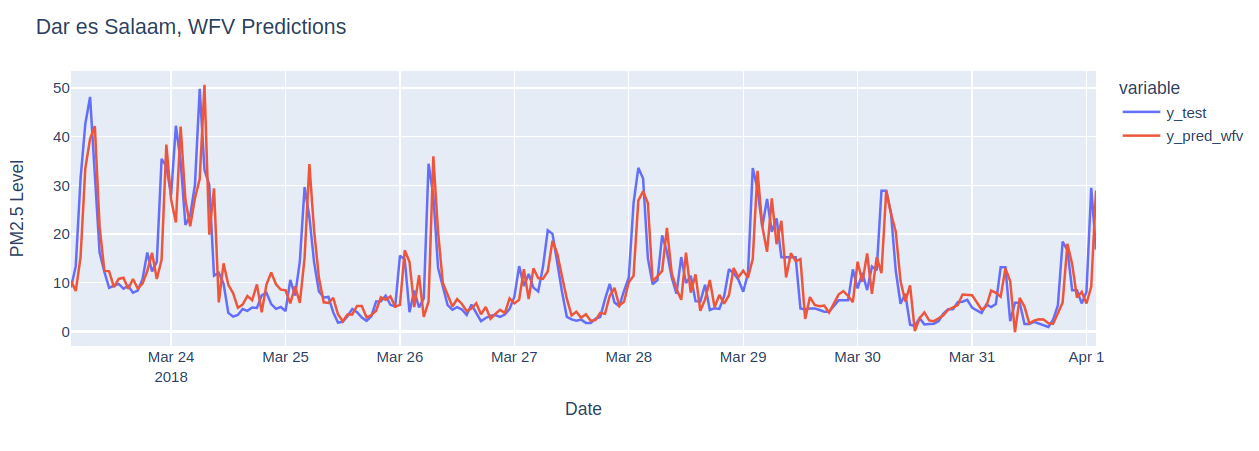